In [11]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras import regularizers, Model
from keras.layers import Dense, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
import random
import shutil

#from tensorflow.keras.applications.xception import preprocess_input

## Setup data splits in generators

In [12]:
target = 256 # number of pixels. change this to 512 if you want to use the full image size. note: will slow computations

dataPath = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg/'

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0)
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    #image = preprocess_input(image)
    return image

# combine two unique generators using noise injection and moderate preprocessing
batchSize = 8
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True, channel_shift_range=10, width_shift_range=0.05, height_shift_range=0.05,rotation_range=360,shear_range=30, brightness_range=(0.95, 1.05),  fill_mode = 'constant', cval=0, zoom_range=0.05)
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=None)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=None)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


## Create a ConvNeXtTiny instance

In [13]:
# simple model that uses ConvNeXtTiny backbone; accomodate for overfitting with a regularized dense layer after backbone
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    transfer = keras.applications.ConvNeXtTiny(
        weights='imagenet', include_preprocessing=True, include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = GlobalMaxPool2D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

111650432/111650432 [==============================] - 4s 0us/step


## Model Meta-Learning Configurations

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=1, min_lr=1e-5)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Model Training
Note: No training on the doubled dataset yet for quicker convergence

In [15]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen1, steps_per_epoch = len(trainGen1),validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 62.9626 - binary_accuracy: 0.8112 - auc: 0.8910 - precision: 0.8112 - recall: 0.8112

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 320s 279ms/step - loss: 62.9626 - binary_accuracy: 0.8112 - auc: 0.8910 - precision: 0.8112 - recall: 0.8112 - val_loss: 1.3179 - val_binary_accuracy: 0.8909 - val_auc: 0.9556 - val_precision: 0.9123 - val_recall: 0.8649 - lr: 1.0000e-04
Epoch 2/20
1000/1000 [==============================] - 232s 232ms/step - loss: 0.6840 - binary_accuracy: 0.8763 - auc: 0.9431 - precision: 0.8687 - recall: 0.8865 - val_loss: 0.4904 - val_binary_accuracy: 0.8818 - val_auc: 0.9582 - val_precision: 0.9509 - val_recall: 0.8052 - lr: 1.0000e-04
Epoch 3/20
1000/1000 [==============================] - 229s 229ms/step - loss: 0.4461 - binary_accuracy: 0.8876 - auc: 0.9517 - precision: 0.8856 - recall: 0.8903 - val_loss: 0.3937 - val_binary_accuracy: 0.9195 - val_auc: 0.9730 - val_precision: 0.9027 - val_recall: 0.9403 - lr: 1.0000e-04
Epoch 4/20
1000/1000 [==============================] - 228s 228ms/step - loss: 0.4060 - binary_accuracy: 0.8979 - auc: 0.9574 - pr

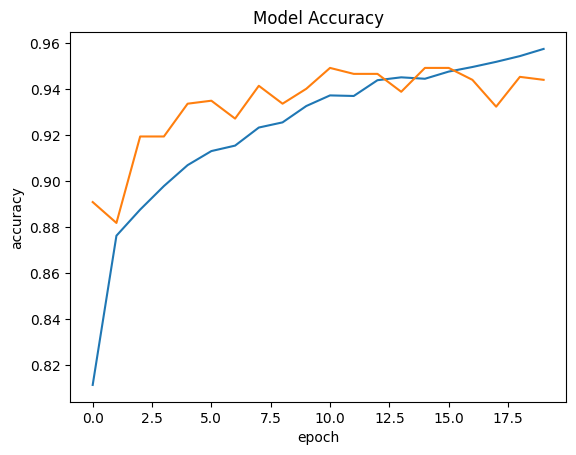

In [16]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [17]:
# evaluate using best epoch model according to validation loss
model.save('pretrained.h5')
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 19s 24ms/step - loss: 0.2715 - binary_accuracy: 0.9338 - auc: 0.9764 - precision: 0.9260 - recall: 0.9429


[0.2715117335319519,
 0.93376624584198,
 0.9763973355293274,
 0.9260203838348389,
 0.9428571462631226]

# Double training data with the other uniqely seeded training generator to prevent overfitting and continue training

In [18]:
model.load_weights('pretrained.h5')
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 431s 216ms/step - loss: 0.1971 - binary_accuracy: 0.9595 - auc: 0.9906 - precision: 0.9569 - recall: 0.9624 - val_loss: 0.2419 - val_binary_accuracy: 0.9494 - val_auc: 0.9818 - val_precision: 0.9529 - val_recall: 0.9455 - lr: 6.9834e-05
Epoch 2/5
2000/2000 [==============================] - 430s 215ms/step - loss: 0.1900 - binary_accuracy: 0.9616 - auc: 0.9910 - precision: 0.9581 - recall: 0.9655 - val_loss: 0.2414 - val_binary_accuracy: 0.9481 - val_auc: 0.9821 - val_precision: 0.9412 - val_recall: 0.9558 - lr: 6.9834e-05
Epoch 3/5
2000/2000 [==============================] - 429s 215ms/step - loss: 0.1795 - binary_accuracy: 0.9666 - auc: 0.9925 - precision: 0.9636 - recall: 0.9697 - val_loss: 0.2378 - val_binary_accuracy: 0.9494 - val_auc: 0.9816 - val_precision: 0.9303 - val_recall: 0.9714 - lr: 6.9834e-05
Epoch 4/5
2000/2000 [==============================] - 430s 215ms/step - loss: 0.1699 - binary_accuracy: 0.9693 - auc: 0.993

In [19]:
model.save('pretrained2.h5')
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 19s 24ms/step - loss: 0.2828 - binary_accuracy: 0.9260 - auc: 0.9795 - precision: 0.9039 - recall: 0.9532


[0.28279930353164673,
 0.9259740114212036,
 0.9794906377792358,
 0.9039409160614014,
 0.9532467722892761]

## With the help of a large deep learning model and advanced preprocessing to prevent overfitting, the benchmrk has improved!

# 2nd way of DL

Install Dependencies and Setup

In [ ]:
# Install necessary libraries (if not already installed)
!pip install -q tensorflow keras

In [20]:


import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


**Dataset Setup**

In [21]:
# Define dataset paths
DATASET_PATH = "/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg/"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VALID_DIR = os.path.join(DATASET_PATH, "validation")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Data Augmentation for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


**Model Definition (Transfer Learning)**

In [22]:
# Load pre-trained model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 1s 0us/step


**Training**

In [23]:
# Callbacks for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze the base model and fine-tune
for layer in base_model.layers:
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


2024-11-17 16:01:02.428905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 113s 423ms/step - loss: 0.7013 - accuracy: 0.5119 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 107s 426ms/step - loss: 0.6944 - accuracy: 0.5107 - val_loss: 0.6935 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 102s 409ms/step - loss: 0.6940 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 102s 410ms/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 102s 410ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 6/20
250/250 [==============================] - 105s 420ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 7/20
250/250 [=============================

2024-11-17 16:15:16.059005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 149s 430ms/step - loss: 0.8305 - accuracy: 0.5393 - val_loss: 0.6995 - val_accuracy: 0.4987 - lr: 1.0000e-05
Epoch 2/10
250/250 [==============================] - 107s 429ms/step - loss: 0.6917 - accuracy: 0.6053 - val_loss: 0.6563 - val_accuracy: 0.6065 - lr: 1.0000e-05
Epoch 3/10
250/250 [==============================] - 107s 427ms/step - loss: 0.6366 - accuracy: 0.6503 - val_loss: 0.6564 - val_accuracy: 0.6208 - lr: 1.0000e-05
Epoch 4/10
250/250 [==============================] - 107s 428ms/step - loss: 0.5967 - accuracy: 0.6809 - val_loss: 0.5885 - val_accuracy: 0.6935 - lr: 1.0000e-05
Epoch 5/10
250/250 [==============================] - 108s 431ms/step - loss: 0.5553 - accuracy: 0.7193 - val_loss: 0.6496 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 6/10
250/250 [==============================] - 108s 431ms/step - loss: 0.5324 - accuracy: 0.7309 - val_loss: 0.7328 - val_accuracy: 0.5571 - lr: 1.0000e-05
Epoch 7/10
250/250 [=============

**Save the Model**

In [24]:
# Save the trained model
model.save("/kaggle/working/glaucoma_detection_model.h5")


**Prediction on Test Data**

In [25]:
# Load the saved model
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/glaucoma_detection_model.h5")

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,  # No labels
    shuffle=False
)

# Predict
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Map predictions to filenames
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Prediction": predicted_classes.ravel()})

# Save results to a CSV
results.to_csv("/kaggle/working/predictions.csv", index=False)


Found 770 images belonging to 2 classes.
770/770 [==============================] - 9s 9ms/step


**Visualize Training Results**

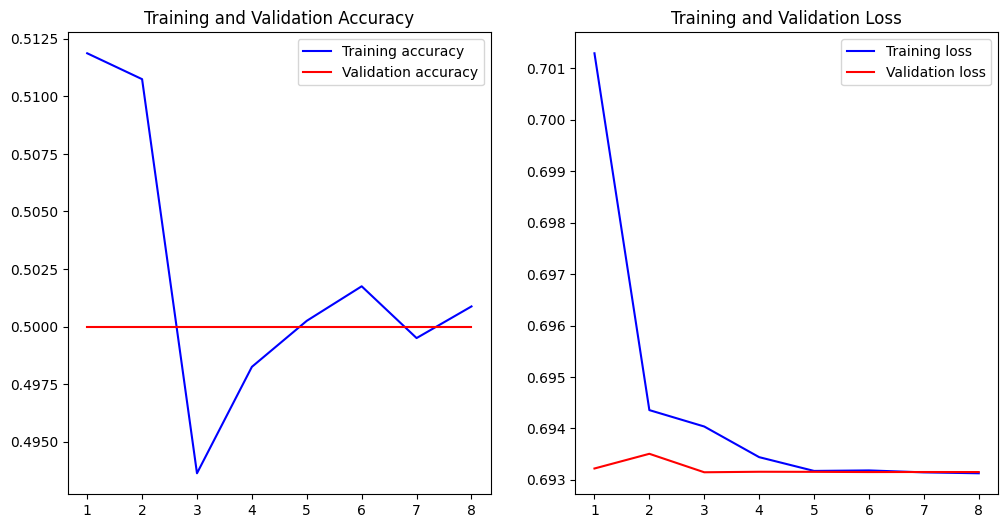

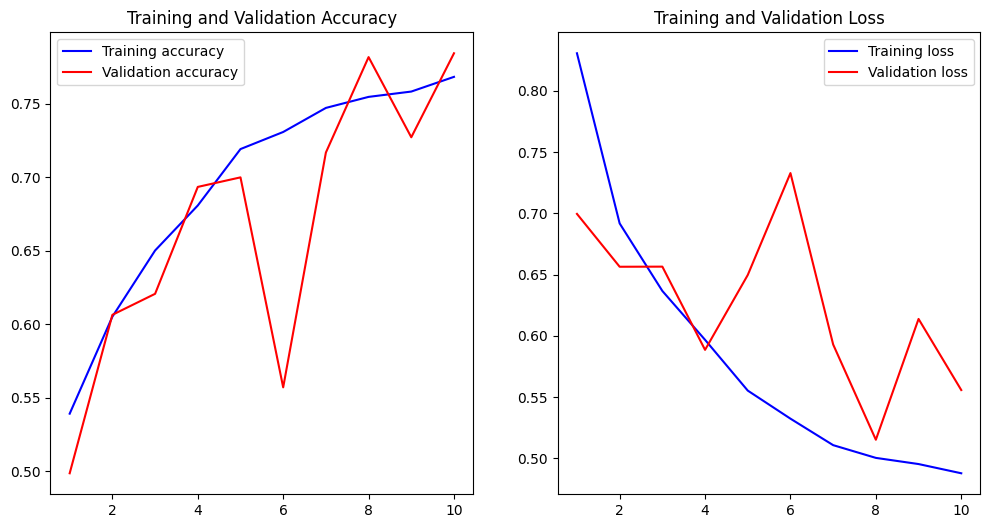

In [26]:
# Plot training history
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training(history)
plot_training(history_finetune)


In [27]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model("/kaggle/working/glaucoma_detection_model.h5")

def predict_glaucoma(image_path, model):
    """
    Predict if an image indicates glaucoma.

    Args:
    image_path (str): Path to the image file.
    model (tf.keras.Model): Trained Keras model.

    Returns:
    str: Prediction result ("Glaucoma Detected" or "No Glaucoma").
    """
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))  # Resize to model's input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image

        # Predict using the model
        prediction = model.predict(img_array)
        result = "Glaucoma Detected" if prediction[0][0] > 0.5 else "No Glaucoma"

        return result
    except Exception as e:
        return f"Error: {str(e)}"

# Test the function with an image
# Replace this path with the path to your test image
image_path = "/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg/validation/RG/EyePACS-TRAIN-RG-2502.jpg"

result = predict_glaucoma(image_path, model)
print(f"Prediction: {result}")


1/1 [==============================] - 2s 2s/step
Prediction: No Glaucoma
